In [53]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
import statsmodels.api as sm
from scipy.stats import skew
import warnings

In [54]:
warnings.filterwarnings("ignore")

In [55]:
# Load dataset
df = pd.read_csv("tea_forex.csv", parse_dates=["Year-Month"], index_col="Year-Month")

In [56]:
df.head()

,High_Grown_Production_(Kg),Mid_Grown_Production_(Kg),Low_Grown_Production_(Kg),National_Production_(Kg),FEE_(Million_USD)
Year-Month,,,,,
2012-01-01,5361185.05,3652353.15,14348315.90,23361854.10,95.32
2012-02-01,5538399.31,3955745.75,13133213.00,22627358.06,100.17
2012-03-01,6385525.09,4625138.90,17929328.00,28939991.99,130.31
2012-04-01,7323011.00,5748401.20,16982493.50,30053905.70,110.41
2012-05-01,8726319.70,5898297.10,18086627.25,32711244.05,149.19


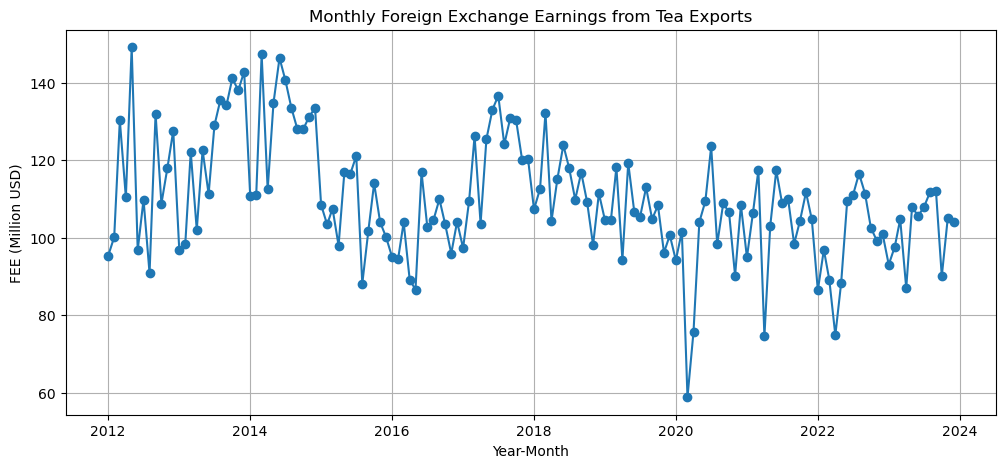

In [57]:
# Plot the time series
plt.figure(figsize=(12, 5))
plt.plot(df['FEE_(Million_USD)'], marker='o', linestyle='-')
plt.title("Monthly Foreign Exchange Earnings from Tea Exports")
plt.xlabel("Year-Month")
plt.ylabel("FEE (Million USD)")
plt.grid()
plt.show()

In [58]:
# Augmented Dickey-Fuller (ADF) Test for stationarity
def adf_test(series):
    result = adfuller(series)
    print("ADF Statistic:", result[0])
    print("p-value:", result[1])
    print("Critical Values:", result[4])
    if result[1] <= 0.05:
        print("Series is stationary.")
    else:
        print("Series is NOT stationary.")

In [59]:
print("ADF Test Before Differencing:")
adf_test(df["FEE_(Million_USD)"])

ADF Test Before Differencing:
ADF Statistic: -2.132880924046966
p-value: 0.23150015682751962
Critical Values: {'1%': -3.4816817173418295, '5%': -2.8840418343195267, '10%': -2.578770059171598}
Series is NOT stationary.


In [60]:
print("Skewness before Box-Cox:", skew(df["FEE_(Million_USD)"]))
# If skewness is between -1 and 1, transformation isn’t needed.

Skewness before Box-Cox: 0.14176181466959217


In [61]:
# First Differencing
df["FEE_Diff"] = df["FEE_(Million_USD)"].diff().dropna()

In [62]:
print("ADF Test After First Differencing:")
adf_test(df["FEE_Diff"].dropna())

ADF Test After First Differencing:
ADF Statistic: -3.3914369173972982
p-value: 0.011254273368081267
Critical Values: {'1%': -3.4816817173418295, '5%': -2.8840418343195267, '10%': -2.578770059171598}
Series is stationary.


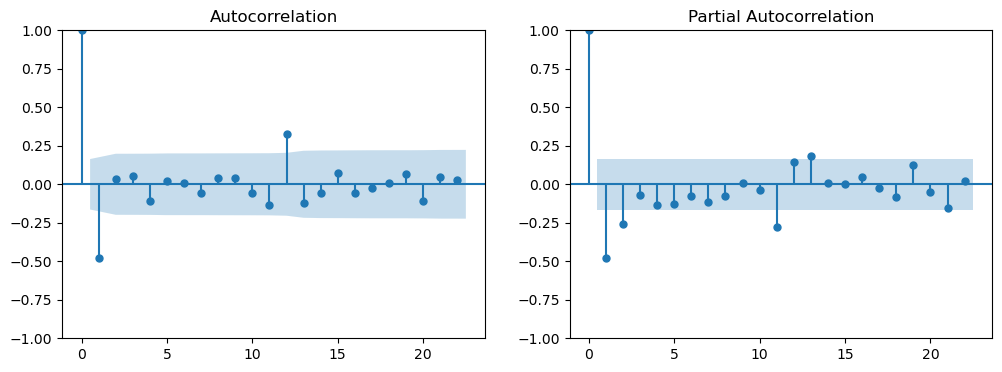

In [63]:
# ACF & PACF Plots to determine ARIMA parameters
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
plot_acf(df["FEE_Diff"].dropna(), ax=axes[0])
plot_pacf(df["FEE_Diff"].dropna(), ax=axes[1])
plt.show()

In [64]:
# Split data into train and test sets
train_size = int(len(df) * 0.8)
train, test = df["FEE_(Million_USD)"][:train_size], df["FEE_(Million_USD)"][train_size:]

In [90]:
# Train ARIMA Model
p, d, q = 11, 1, 12
model = ARIMA(train, order=(p, d, q)).fit()

In [91]:
# Print Model Summary
print(model.summary())

                               SARIMAX Results                                
Dep. Variable:      FEE_(Million_USD)   No. Observations:                  115
Model:               ARIMA(11, 1, 12)   Log Likelihood                -445.238
Date:                Sun, 16 Mar 2025   AIC                            938.477
Time:                        10:50:59   BIC                           1004.145
Sample:                    01-01-2012   HQIC                           965.128
                         - 07-01-2021                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.1152      0.177     -6.308      0.000      -1.462      -0.769
ar.L2         -0.8734      0.226     -3.867      0.000      -1.316      -0.431
ar.L3         -0.4856      0.245     -1.984      0.0

In [92]:
# Forecast future values
forecast = model.forecast(steps=len(test))

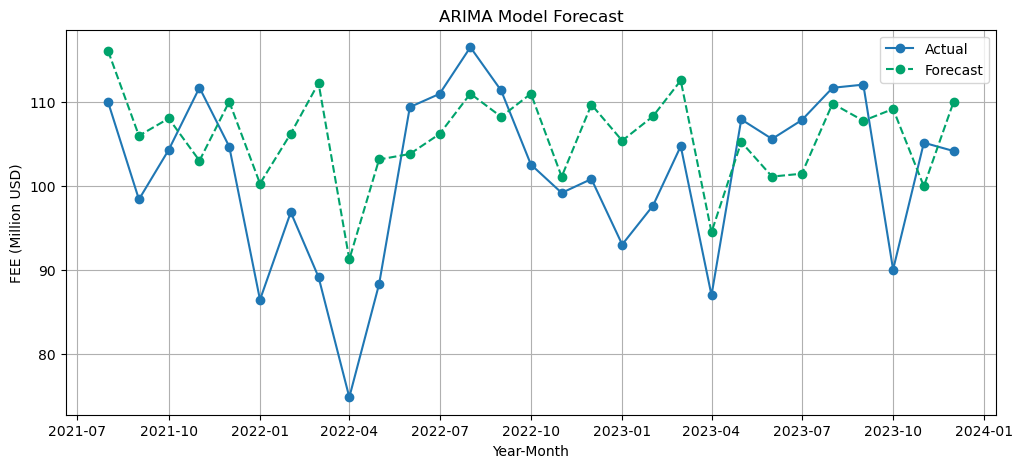

In [93]:
# Plot Actual vs. Forecast
plt.figure(figsize=(12, 5))
plt.plot(df.index[train_size:], test, label="Actual", marker="o")
plt.plot(df.index[train_size:], forecast, label="Forecast", marker="o", color='#00A36C', linestyle="dashed")
plt.title("ARIMA Model Forecast")
plt.xlabel("Year-Month")
plt.ylabel("FEE (Million USD)")
plt.legend()
plt.grid()
plt.show()

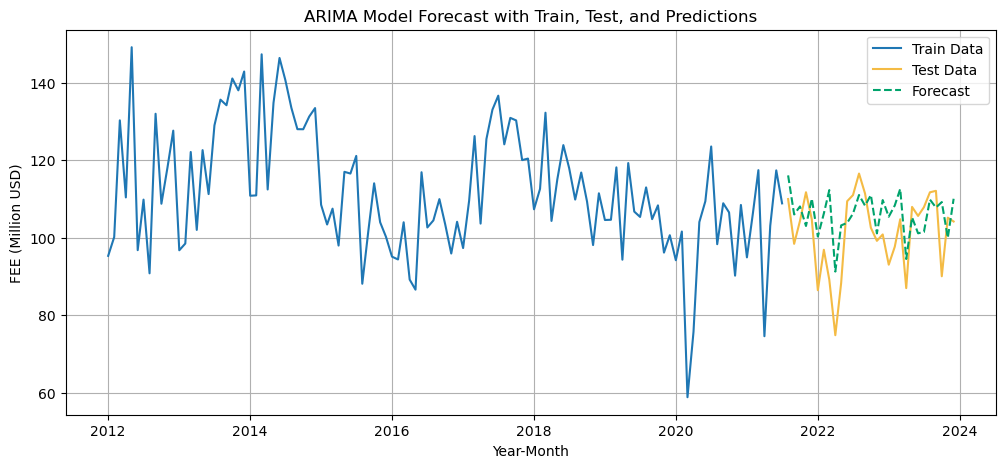

In [69]:
# Plot Actual vs. Forecast, including train and test data
plt.figure(figsize=(12, 5))
plt.plot(df.index[:train_size], train, label="Train Data")
plt.plot(df.index[train_size:], test, label="Test Data", color="#F4BB44")
plt.plot(df.index[train_size:], forecast, label="Forecast", color="#00A36C", linestyle="dashed")
plt.title("ARIMA Model Forecast with Train, Test, and Predictions")
plt.xlabel("Year-Month")
plt.ylabel("FEE (Million USD)")
plt.legend()
plt.grid()
plt.show()

In [70]:
# Model Evaluation
mse = mean_squared_error(test, forecast)
rmse = np.sqrt(mse)
mape = mean_absolute_percentage_error(test, forecast)

print(f"\nModel Evaluation Metrics:")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"Mean Absolute Percentage Error (MAPE): {mape * 100:.4f}")
print(f"Akaike Information Criterion (AIC): {model.aic:.4f}")


Model Evaluation Metrics:
Mean Squared Error (MSE): 92.1687
Root Mean Squared Error (RMSE): 9.6005
Mean Absolute Percentage Error (MAPE): 8.5038
Akaike Information Criterion (AIC): 938.4767


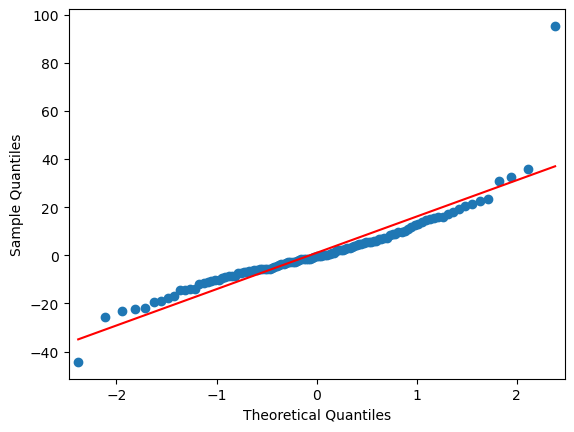

In [71]:
residuals = model.resid
sm.qqplot(residuals, line='s')
plt.show()
# If residuals deviate significantly from normality, more tuning is needed.